In [7]:
import pandas as pd
from allocations import Allocations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
methods = [
    "bootstrap_nn",
    "awp",
    "nn_variance",
    "fasterrisk"]

labels = {
    "bootstrap_nn": "Training Data",
    "awp": "Model Perturbation",
    "nn_variance": "Model Initialization",
    "fasterrisk": "Feature Selection"
}


SELECTION_RATE = 0.25
QUALIFICATION_COLUMN = "qualified_gagne_2"
ITERATIONS_PER_SPLIT = 25
TEST_SIZE = 1000
RASHOMON_EPSILON = 0.01

output_file = "outcome_homogenization.jpg"

In [11]:
all_results = {}
baseline = []
for m in methods:
    print(m)
    #df = pd.read_csv("results/"+m+"_"+QUALIFICATION_COLUMN+".csv")
    if m == "fasterrisk":
        df = pd.read_csv("fasterrisk_qualified_gagne_2.csv")
    elif m == "bootstrap_nn":
        df = pd.read_csv("test_bootstrap_lr_qualified_gagne_2.csv")
    else:
        continue
    a = Allocations(df, TEST_SIZE, SELECTION_RATE, "y", RASHOMON_EPSILON, ITERATIONS_PER_SPLIT)
    allocations, people = a.get_allocations()

    results = []
    for seed in allocations["seed"].unique():
        for iteration in allocations["iteration"].unique():
            curr_people = list(people.loc[((people["seed"]==seed)&(people["iteration"]==iteration)), "people"])[0]
            selected_counts = dict.fromkeys(curr_people, 0)
    
            curr_allocations = allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "selected"].to_list()
            for a in curr_allocations:
                for p in a:
                    selected_counts[p] += 1
    
            results += [(value / len(curr_allocations))**2 + (1 - (value / len(curr_allocations)))**2 for value in selected_counts.values()]

            n_prime = allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "n'"].mean()
            k_prime = allocations.loc[(allocations["seed"]==seed)&(allocations["iteration"]==iteration), "k'"].mean()
            qualified_prob = k_prime / n_prime
            qualified_entropy = qualified_prob**2 + (1 - qualified_prob)**2
            unqualified_prob = ((TEST_SIZE*SELECTION_RATE) - k_prime) / (TEST_SIZE - n_prime)
            unqualified_entropy = unqualified_prob**2 + (1 - unqualified_prob)**2
            baseline.append((qualified_entropy * (n_prime / TEST_SIZE)) + (unqualified_entropy * ((TEST_SIZE-n_prime)/TEST_SIZE)))

    all_results[m] = results

bootstrap_nn
awp
nn_variance
fasterrisk


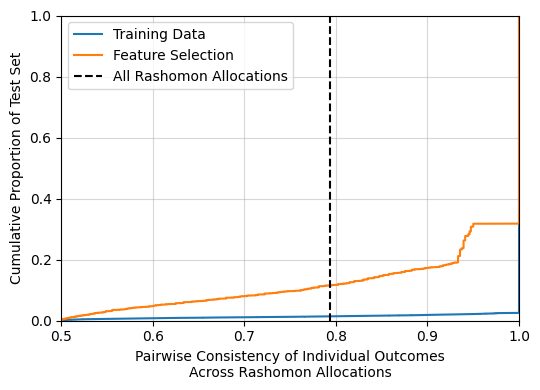

In [21]:
fig = plt.figure(figsize=(5.5,4))

for m in all_results.keys():
    results_sorted = np.sort(all_results[m])
    cdf = np.arange(1, len(results_sorted) + 1) / len(results_sorted)
    plt.plot(results_sorted, cdf, label=labels[m])

plt.axvline(x=np.mean(baseline), color='k', linestyle='--', label="All Rashomon Allocations")


plt.xlim([0.5, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('Pairwise Consistency of Individual Outcomes\nAcross Rashomon Allocations')
plt.ylabel('Cumulative Proportion of Test Set')
plt.legend(loc="upper left")
plt.grid(True, alpha=0.5)
fig.tight_layout()
fig.savefig(output_file, dpi=500)